### ▶️ Now lets import some python-libraries

In [2]:
import pandas as pd
import datetime
from IPython.display import display, HTML

### ▶️ Reading the prepared data from Google-Drive

#### This takes about 50 !! seconds to load... 
---

- Dataset includes a time period from 20-01-2014 till 20-01-2024
- It contents measurements for "Mittlere Temperatur", "Sonnenscheindauer" and "Windgeschwindigkeit"
- To made this a real world project with big data, it includes ALL german weather stations
- In summary the .csv-file contains over 3 Million datapoints and has a size of nearly 200 MegaBytes

In [3]:
# Import the .csv-file with the weather datasets
df = pd.read_csv('https://drive.usercontent.google.com/download?id=11DYEiMTRVhMySsH5r3cDfCWBU2mqlNqO&export=download&authuser=0&confirm=t&uuid=1aa8951f-3209-4a18-986c-229dfc0f29e2&at=APZUnTVUwg__SVFWwQUEz9ft2zsy:1705864211167', index_col=False)

df.head()

,Zeitstempel,Wert,Kategorie,Station
0,2014-01-20,-1.2,Mittlere Temperatur,Doberlug-Kirchhain
1,2014-01-21,-2.0,Mittlere Temperatur,Doberlug-Kirchhain
2,2014-01-22,-4.4,Mittlere Temperatur,Doberlug-Kirchhain
3,2014-01-23,-4.5,Mittlere Temperatur,Doberlug-Kirchhain
4,2014-01-24,-5.3,Mittlere Temperatur,Doberlug-Kirchhain


### ▶️ We have to convert our datatypes first

In [4]:

# Convert "Zeitstempel" to dateTime
df['Zeitstempel'] = pd.to_datetime(df.Zeitstempel)

# Convert "Station" to String
df['Station'] = df['Station'].astype("string")

# Convert "Produkt_Titel" to String
df['Kategorie'] = df['Kategorie'].astype("string")


### ▶️ Now we can start to filter our data

In [199]:
""" pd.set_option('display.max_colwidth', None)

def display_side_by_side(dfs:list, captions:list):
    #Display tables side by side to save vertical space
    #Input:
    #    dfs: list of pandas.DataFrame
    #    captions: list of table captions
    
    #output = ""
    #combined = dict(zip(captions, dfs))
    #for caption, df in combined.items():
    #    output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
    #    output += "\xa0\xa0\xa0\xa0\xa0"
    #display(HTML(output))

# We take the data for "Sonnenscheindauer"
df_sunshine = df.loc[(df['Kategorie'] == "Sonnenscheindauer")].reset_index(drop=True)
df_sunshine_2 = df_sunshine.groupby('Station')

# We group our pre-chosen "Sonnenscheindauer" data by station, then we aggregate Minimum, Maximum, Mean and Variance

# Sub-set is finally sorted by Minimum in a ascending manner
df_sunshine_min = df_sunshine.groupby('Station')[['Wert']].agg(['min']).sort_values(by=('Wert','min'),ascending=True).reset_index()

# Sub-set is finally sorted by Maximum in a ascending manner
df_sunshine_max = df_sunshine.groupby('Station')[['Wert']].agg(['max']).sort_values(by=('Wert','max'),ascending=False).reset_index()

# Sub-result is finally sorted by Maximum in a ascending manner
df_sunshine_var = df_sunshine.groupby('Station')[['Wert']].agg(['var']).sort_values(by=('Wert','var'),ascending=True).reset_index()

# Sub-result is finally sorted by Mean in a ascending manner
df_sunshine_mean = df_sunshine.groupby('Station')[['Wert']].agg(['mean']).sort_values(by=('Wert','mean'),ascending=False).reset_index()
#df_sunshine_mean = df_sunshine_mean.loc[(df['Wert'] >= 2.0)]

# We resolve the mulitindex to a single index, and give the columns a nicer name
df_sunshine_max.columns = ['Station', 'Maximalwerte']
df_sunshine_min.columns = ['Station', 'Minimalwerte']
df_sunshine_mean.columns = ['Station', 'Mittelwerte']
df_sunshine_var.columns = ['Station', 'Varianzen']

#display_side_by_side([df_sunshine_min[0:10], df_sunshine_max[0:10], df_sunshine_mean[0:10], df_sunshine_var[0:10]], ['Minima absteigend', 'Maxima absteigend', 'Mittelwerte absteigend', 'Varianzen aufsteigend']) """

' pd.set_option(\'display.max_colwidth\', None)\n\ndef display_side_by_side(dfs:list, captions:list):\n    #Display tables side by side to save vertical space\n    #Input:\n    #    dfs: list of pandas.DataFrame\n    #    captions: list of table captions\n    \n    #output = ""\n    #combined = dict(zip(captions, dfs))\n    #for caption, df in combined.items():\n    #    output += df.style.set_table_attributes("style=\'display:inline\'").set_caption(caption)._repr_html_()\n    #    output += "\xa0\xa0\xa0\xa0\xa0"\n    #display(HTML(output))\n\n# We take the data for "Sonnenscheindauer"\ndf_sunshine = df.loc[(df[\'Kategorie\'] == "Sonnenscheindauer")].reset_index(drop=True)\ndf_sunshine_2 = df_sunshine.groupby(\'Station\')\n\n# We group our pre-chosen "Sonnenscheindauer" data by station, then we aggregate Minimum, Maximum, Mean and Variance\n\n# Sub-set is finally sorted by Minimum in a ascending manner\ndf_sunshine_min = df_sunshine.groupby(\'Station\')[[\'Wert\']].agg([\'min\']).sort

#### Anaylse des Kriteriums "Mittlere Tagestemperatur"

- Für unseren idealen Wohnort müssen wir folgende Kriterien einhalten:

❗ Die maximale Temperatur soll 25°C nicht übersteigen, zu keinem Zeitpunkt</br>
❗ Wir suchen den Ort mit den geringsten Wetterveränderungen, und berechnen dazu die Varianz und Standarabweichung</br>
❗ An Orten mit der geringsten Standardabweichung, herrschen die geringsten Abweichungen vom Temperaturmittelwert</br>
❗ Das bedeutet an diesen Orten gibt es die geringsten Schwankungen in der Temperatur über die Zeit


In [274]:
df_temp = df.loc[((df['Kategorie'] == "Mittlere Temperatur") & (df['Wert'] <= 25.0) & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]
df_sun = df.loc[((df['Kategorie'] == "Sonnenscheindauer") & (df['Wert'] > 4.0) & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]
df_wind = df.loc[((df['Kategorie'] == "Windgeschwindigkeit") & (df['Wert'] < 2.0) & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]

In [275]:
#df_mean = df_mean.set_index('Zeitstempel')
#print(df_temp.reset_index(drop=True))
df_temp.info

<bound method DataFrame.info of         Zeitstempel  Wert            Kategorie                  Station
2538     2021-01-01   1.7  Mittlere Temperatur       Doberlug-Kirchhain
2539     2021-01-02   0.0  Mittlere Temperatur       Doberlug-Kirchhain
2540     2021-01-03   0.4  Mittlere Temperatur       Doberlug-Kirchhain
2541     2021-01-04   0.4  Mittlere Temperatur       Doberlug-Kirchhain
2542     2021-01-05   0.4  Mittlere Temperatur       Doberlug-Kirchhain
...             ...   ...                  ...                      ...
3634892  2024-01-16  -2.2  Mittlere Temperatur  Dippoldiswalde-Reinberg
3634893  2024-01-17  -2.1  Mittlere Temperatur  Dippoldiswalde-Reinberg
3634894  2024-01-18  -2.4  Mittlere Temperatur  Dippoldiswalde-Reinberg
3634895  2024-01-19  -3.7  Mittlere Temperatur  Dippoldiswalde-Reinberg
3634896  2024-01-20  -3.2  Mittlere Temperatur  Dippoldiswalde-Reinberg

[547521 rows x 4 columns]>

Calculation of important statistical values over a period of the last 3 years

In [429]:
# Get the calculations for "min", "max", "mean", "var" and "std" for all stations, sorted by "std"
# Legend :
# "min"  --> minmial temperatures during the last 3 years of all german weather stations
# "max"  --> maximal temperatures during the last 3 years of all german weather stations
# "mean" --> median  temperatures during the last 3 years of all german weather stations
# "var"  --> variance values during the last 3 years of all german weather stations
# "std"  --> standard deviation values during the last 3 years of all german weather stations

df_calc_temp = df_temp.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).reset_index()
df_calc_sun = df_sun.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).reset_index()
df_calc_wind = df_wind.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).dropna().reset_index()

df_calc_temp.columns = ["_".join(c) for c in df_calc_temp.columns]
df_calc_temp = df_calc_temp.rename(columns={'Wert_min':'Temperatur [min]', 'Wert_max':'Temperatur [max]', 'Wert_mean':'Temperatur [med]'})
df_calc_temp = df_calc_temp.rename(columns={'Station_': 'Station', 'Wert_var':'Temperatur [var]', 'Wert_std':'Temperatur [std]'})

df_calc_sun.columns = ["_".join(c) for c in df_calc_sun.columns]
df_calc_sun = df_calc_sun.rename(columns={'Wert_min':'Sonne [min]', 'Wert_max':'Sonne [max]', 'Wert_mean':'Sonne [med]'})
df_calc_sun = df_calc_sun.rename(columns={'Station_': 'Station', 'Wert_var':'Sonne [var]', 'Wert_std':'Sonne [std]'})

df_calc_wind.columns = ["_".join(c) for c in df_calc_wind.columns]
df_calc_wind = df_calc_wind.rename(columns={'Wert_min':'Wind [min]', 'Wert_max':'Wind [max]', 'Wert_mean':'Wind [med]'})
df_calc_wind = df_calc_wind.rename(columns={'Station_': 'Station', 'Wert_var':'Wind [var]', 'Wert_std':'Wind [std]'})

#print(df_calc_wind.columns)

df_result = pd.merge(df_calc_temp, df_calc_sun, on="Station")
df_result = pd.merge(df_result, df_calc_wind, on="Station")

#print(df_result.columns)

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


# Show a sample
df_result.head(10).style.bar(subset=('Temperatur [std]'), color='blue').bar(subset=('Sonne [std]'), color='#7715ea').bar(subset=('Wind [std]'), color='#074bf8')

,Station,Temperatur [min],Temperatur [max],Temperatur [med],Temperatur [var],Temperatur [std],Sonne [min],Sonne [max],Sonne [med],Sonne [var],Sonne [std],Wind [min],Wind [max],Wind [med],Wind [var],Wind [std]
0,UFS TW Ems,0.700000,20.700000,10.551172,22.917689,4.787242,4.017000,16.400000,8.608063,10.510199,3.241944,1.600000,1.900000,1.775000,0.022500,0.150000
1,UFS Deutsche Bucht,0.900000,21.700000,11.940238,23.181252,4.814691,4.033000,16.300000,8.886109,9.819489,3.133606,1.300000,1.900000,1.700000,0.120000,0.346410
2,Berlin-Tegel,-9.100000,14.400000,3.803226,24.081290,4.907269,4.500000,13.900000,7.837500,6.495737,2.548674,1.000000,1.900000,1.593750,0.056625,0.237960
3,Helgoland,-3.100000,22.400000,10.612776,30.143691,5.490327,4.017000,15.717000,8.752615,10.160672,3.187581,1.600000,1.900000,1.760000,0.018000,0.134164
4,Leuchtturm Alte Weser,-3.300000,23.900000,10.555386,33.844270,5.817583,4.033000,15.833000,8.991631,10.119045,3.181045,1.700000,1.900000,1.800000,0.020000,0.141421
5,Norderney,-3.800000,23.700000,10.689946,34.317329,5.858099,4.017000,16.250000,8.945423,10.349364,3.217043,1.800000,1.900000,1.833333,0.003333,0.057735
6,Schönhagen (Ostseebad),-5.900000,23.400000,9.847175,37.789370,6.147306,4.033000,16.267000,8.984544,10.003773,3.162874,1.300000,1.900000,1.738889,0.035458,0.188302
7,Emden,-6.700000,24.600000,10.390673,37.823557,6.150086,4.017000,15.767000,8.346768,9.327518,3.054099,1.100000,1.900000,1.677465,0.038628,0.196539
8,Wittmundhafen,-6.800000,24.400000,9.965282,37.934376,6.159089,4.100000,14.200000,7.635526,7.920988,2.814425,1.000000,1.900000,1.576250,0.056517,0.237734
9,Dörpen,-5.500000,25.000000,10.755717,38.080998,6.170980,4.017000,15.867000,8.521372,9.768469,3.125455,0.700000,1.900000,1.561932,0.076657,0.276870


/home/dosmarcos/anaconda3/lib/python3.11/site-packages/seaborn/relational.py:982: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


<Figure size 2500x1000 with 0 Axes>

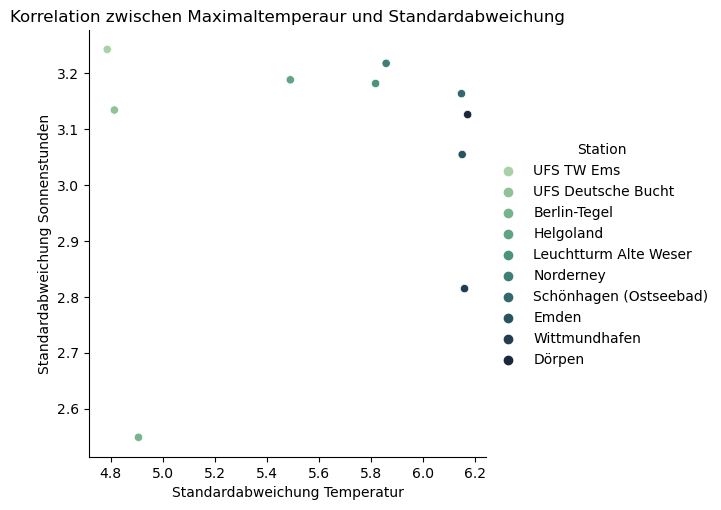

In [391]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(25,10))

plot = sns.relplot(data=df_result[0:10], x=df_result[('Wert_x', 'std')], y=df_result['Wert_y', 'std'], hue="Station", palette="ch:r=-.5,l=.75")
plot.set(title="Korrelation zwischen Maximaltemperaur und Standardabweichung", xlabel="Standardabweichung Temperatur", ylabel="Standardabweichung Sonnenstunden");


In [396]:
# Maximalwert aller Stationen, absteigend, sortiert nach Jahr und Monat
#df_rolling = df_mean.groupby([df_mean["Zeitstempel"].dt.year, df_mean["Zeitstempel"].dt.month, "Station"])[["Wert"]].max().sort_values(by="Wert", ascending=False).dropna()

# Maximalwert aller Stationen, absteigend, sortiert nach Jahr und Monat
#df_rolling = df_mean.groupby(["Station", df_mean["Zeitstempel"].dt.month, df_mean["Zeitstempel"].dt.year])[["Wert"]].mean()
df_rolling = df_temp.groupby(["Station", df_temp["Zeitstempel"].dt.year, df_temp["Zeitstempel"].dt.month])[["Wert"]].mean()

df_rolling = df_rolling.to_flax_index()

AttributeError: 'DataFrame' object has no attribute 'to_flax_index'